# Glass Type Classification


### Problem Difinition
This notebook tries to solve the problem of classfication of glass into its various types. These catagories define the usage of glass in different areas like from building windows to tableware and headlamps

The Dataset used here was obtained from:
https://archive.ics.uci.edu/ml/datasets/Glass+Identification

### Outcome:
 I found out that Random Forest Classifier gives the accuracy of 82.50% on Test Dataset and 98.12% on Train dataset


## Data Dictionary

Features:

* RI: refractive index
* NA: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
* Mg: Magnesium
* Al: Aluminum
* K: Potassium
* Ca: Calcium
* Ba: Barium
* Fe: Iron
*  Type of glass: 
    * 1: building_windows_float_processed
    * 2: building_windows_non_float_processed 
    * 3: vehicle_windows_float_processed
    * 4: vehicle_windows_non_float_processed (none in this database)
    * 5: containers 
    * 6: tableware
    * 7: headlamps

## Importing Base Libraries and Loading Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox

%matplotlib inline

#importing models
from sklearn.linear_model import LogisticRegression
from xgboost import (XGBClassifier, plot_importance)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
data=pd.read_csv('dataset/samples.csv')
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Type is the target variable, so separating out features

In [3]:
#separating features

features = data.columns[:-1].tolist()

In [4]:
#lets check the data types of all data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [5]:
# summerize data
data.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


### Initial Findings

The scale of fetaures is different. For example Si has a mean of 72.65 while Ba has a mean value of 0.175. Features scaling is important for algorithms such as logistic regression (gradient descent) to converge smoothly.

Futher we should check the target variables

In [6]:
data['Type'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

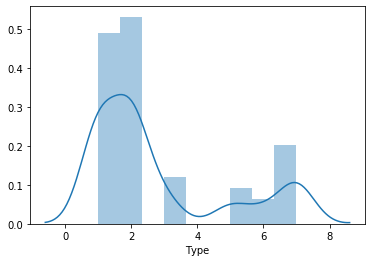

In [7]:
sns.distplot(data['Type'])

So as we can see the distribution is not gaussian and is quite unbalanced, with Types 1 and 3 consituiting more than 50% of data

# Data Visualization

Lets checck the distribution for all features

### Univariate Analysis

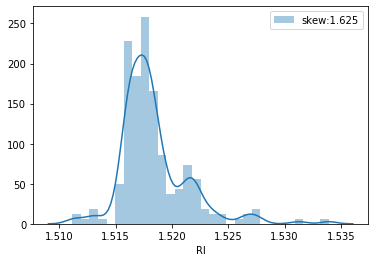

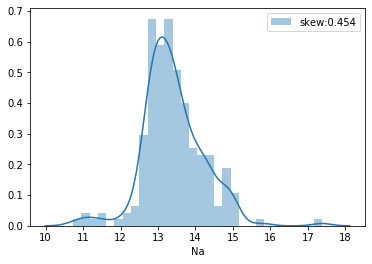

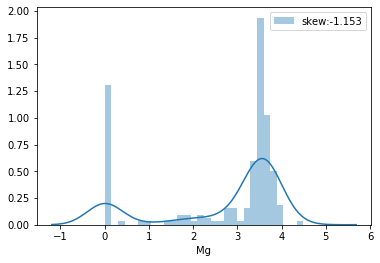

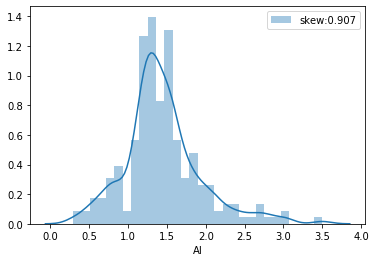

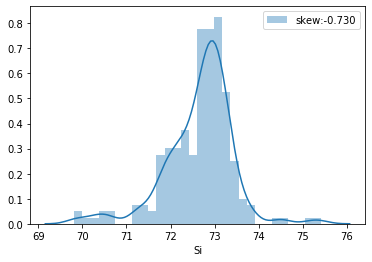

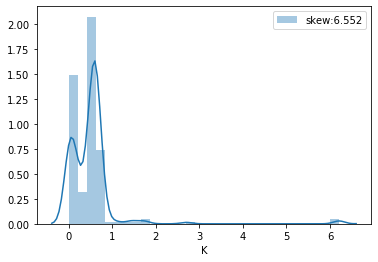

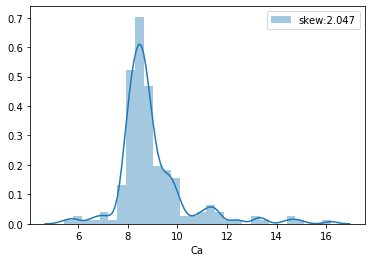

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


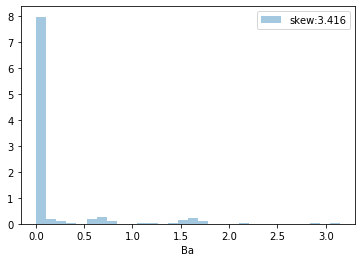

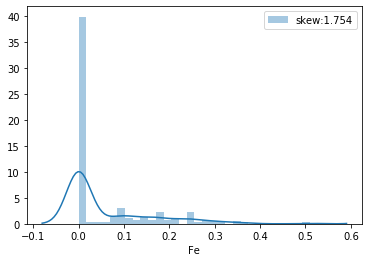

In [8]:
for feature in features:
    skew = data[feature].skew()
    sns.distplot(data[feature],label='skew:%.3f'%(skew),bins=30)
    plt.legend(loc='best')
    plt.show()

As seen from above plots none of the feature is normally distrubted and are highly skewed. Next step will be outlier removal

In [9]:
# outlier detection method

def detect_outliers(df,n,features):
    
    """
    This is implemenation of Tukey Method
    This functin takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 'n' outliers. 
    """
    
    outlier_indices=[]
    
    for col in features:
        
        Q1=np.percentile(df[col],25)
        Q3=np.percentile(df[col],75)
        
        IQR= Q3-Q1
        
        outlier_range=1.5*IQR
        
        outlier_index_list = df[(df[col]<Q1-outlier_range)|((df[col]>Q3+outlier_range))].index
        
        outlier_indices.extend(outlier_index_list)
        
    outlier_indices=Counter(outlier_indices)
    
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers  



In [10]:
#calculating indices of rows in data which contains more that two outliers 
outlier_rows =detect_outliers(data,2,features)

In [11]:
outlier_rows

[103, 105, 106, 107, 110, 111, 184, 185, 189, 163, 171, 172, 186, 207]

In [12]:
len(outlier_rows)

14

Hence more than 14 rows contain outliers, lets see them

In [13]:
data.iloc[outlier_rows]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
103,1.52725,13.80,3.15,0.66,70.57,0.08,11.64,0.00,0.00,2
105,1.52475,11.45,0.00,1.88,72.19,0.81,13.24,0.00,0.34,2
106,1.53125,10.73,0.00,2.10,69.81,0.58,13.30,3.15,0.28,2
107,1.53393,12.30,0.00,1.00,70.16,0.12,16.19,0.00,0.24,2
110,1.52664,11.23,0.00,0.77,73.21,0.00,14.68,0.00,0.00,2
111,1.52739,11.02,0.00,0.75,73.08,0.00,14.96,0.00,0.00,2
184,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.00,0.00,6
185,1.51131,13.69,3.20,1.81,72.81,1.76,5.43,1.19,0.00,7
189,1.52365,15.79,1.83,1.31,70.43,0.31,8.61,1.68,0.00,7
163,1.51514,14.01,2.68,3.50,69.89,1.68,5.87,2.20,0.00,5


Before dropping lets confirm this by visualizing on box plot

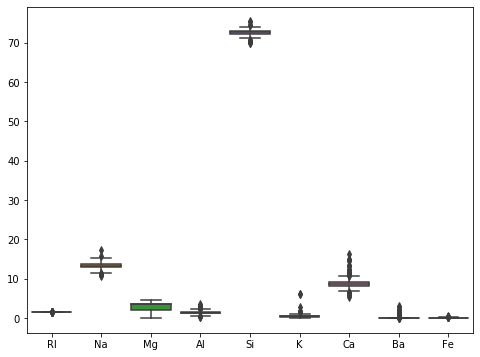

In [14]:
plt.figure(figsize=(8,6))
sns.boxplot(data=data[features])

Outliers are hence confirmed. However, we see mean of silicon is much higheer than any other elements, this is mainly due to the fact that most glass use Silicon as there base

### Multivariate Analysis

Since all the features are numeric, we must chheck the correlaiton between them

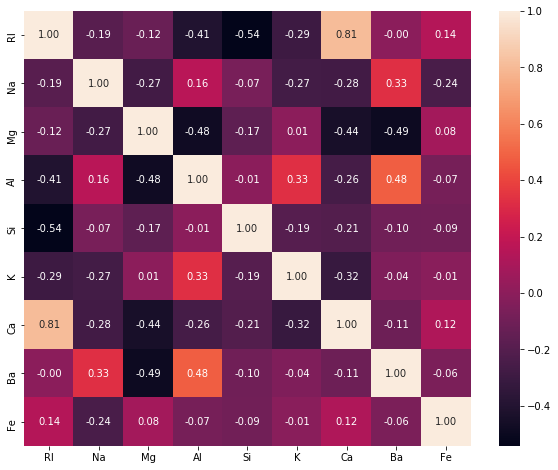

In [15]:
corr = data[features].corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 8))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, annot=True, fmt=".2f")

There seems to be a strong positive correlation between RI and Ca, Al and Ba are also positively correlated

# Data Preprocessing and Feature Engineering

###  Check for null values

In [16]:
data[features].isnull().sum()

RI    0
Na    0
Mg    0
Al    0
Si    0
K     0
Ca    0
Ba    0
Fe    0
dtype: int64

Since there are no null values, we do not need to impute it or fill it

### Remove Outliers

In [17]:
outlier_rows

[103, 105, 106, 107, 110, 111, 184, 185, 189, 163, 171, 172, 186, 207]

In [18]:
# lets drop these rows
data = data.drop(outlier_rows).reset_index(drop=True)

In [19]:
data.shape

(200, 10)

Outliers are now removed

### Data Tranformation

As we saw in data visualizations, most of our features are skewed so we need to perform some kind of transform to normalize the data, generally used methods are log transforms, but there we ll try boxcox. But the normalization of data should be only done on training data to avoid data leakage. Hence lets first divide the data into test and train

In [20]:
X = data[features] # independent variables
y = data['Type'] #target variable
# set a seed and a test size for splitting the dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 4) #setting random seed to have same train test slip everytime

Lets apply our transform now

In [21]:
features_bcox = [] #tranformed features

for feature in features:
    boxcox_feat, _ = boxcox(data[feature]+1)  # adding 1 to avoid computing log of negative values
    features_bcox.append(boxcox_feat)
    
features_bcox = np.column_stack(features_bcox) #stacking list into arrays

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:910: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [22]:
features_bcox

array([[6.15946050e-04, 9.11779768e-01, 3.14083192e+01, ...,
        1.99925016e-01, 0.00000000e+00, 0.00000000e+00],
       [6.15946050e-04, 9.12845932e-01, 1.97224356e+01, ...,
        1.99923566e-01, 0.00000000e+00, 0.00000000e+00],
       [6.15946050e-04, 9.11298873e-01, 1.91611602e+01, ...,
        1.99923459e-01, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.15946050e-04, 9.14755126e-01, 0.00000000e+00, ...,
        1.99924619e-01, 9.11414445e-02, 0.00000000e+00],
       [6.15946050e-04, 9.14833746e-01, 0.00000000e+00, ...,
        1.99924675e-01, 9.11407045e-02, 0.00000000e+00],
       [6.15946050e-04, 9.14238999e-01, 0.00000000e+00, ...,
        1.99924859e-01, 9.11416961e-02, 0.00000000e+00]])

In [23]:
#combine it inot boxcox dataframe
data_bcox = pd.DataFrame(data=features_bcox, columns=features)
data_bcox['Type'] = data['Type']

In [24]:
#lets check it
data_bcox.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0.000616,0.911780,31.408319,0.801044,5.637270e+09,0.058429,0.199925,0.0,0.0,1
1,0.000616,0.912846,19.722436,0.938477,6.065076e+09,0.399352,0.199924,0.0,0.0,1
2,0.000616,0.911299,19.161160,1.026715,6.186702e+09,0.334451,0.199923,0.0,0.0,1
3,0.000616,0.909857,20.757435,0.902711,6.009609e+09,0.460771,0.199924,0.0,0.0,1
4,0.000616,0.910132,19.949682,0.876628,6.229267e+09,0.447403,0.199924,0.0,0.0,1


In [25]:
data_bcox.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,2.000000e+02,200.000000,200.000000,200.000000,2.000000e+02,200.000000,2.000000e+02,200.000000,200.000000,200.000000
mean,6.159461e-04,0.910643,14.813501,0.955244,6.067071e+09,0.342872,1.999249e-01,0.013377,0.019141,2.670000
std,2.173846e-18,0.003076,8.011923,0.217702,2.873472e+08,0.213507,8.577972e-07,0.031188,0.027757,2.054802
min,6.159461e-04,0.897962,0.000000,0.261374,5.004587e+09,0.000000,1.999215e-01,0.000000,0.000000,1.000000
25%,6.159461e-04,0.908540,10.569803,0.850076,5.893126e+09,0.122922,1.999244e-01,0.000000,0.000000,1.000000
50%,6.159461e-04,0.910269,18.555034,0.938477,6.106954e+09,0.447403,1.999248e-01,0.000000,0.000000,2.000000
75%,6.159461e-04,0.912445,19.835863,1.060851,6.238759e+09,0.480536,1.999254e-01,0.000000,0.051652,3.000000
max,6.159461e-04,0.917711,31.408319,1.561947,7.293074e+09,1.392148,1.999270e-01,0.091142,0.068796,7.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


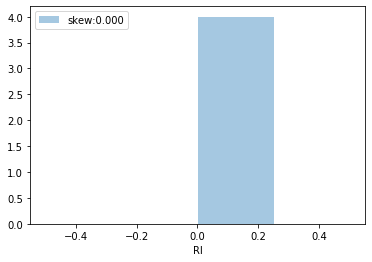

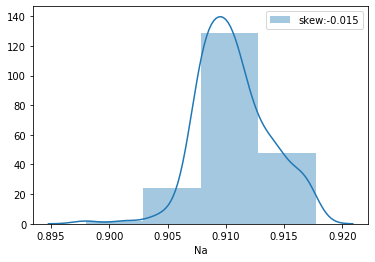

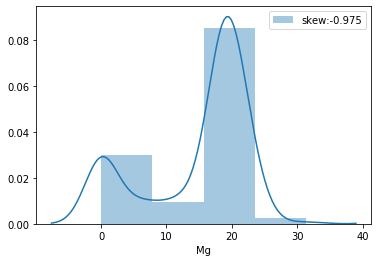

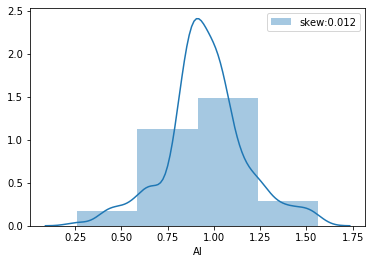

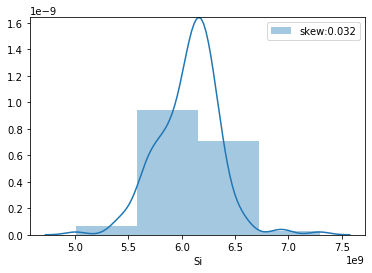

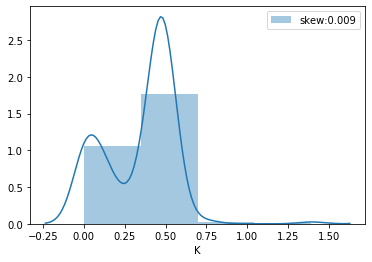

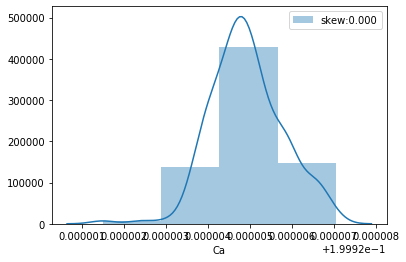

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


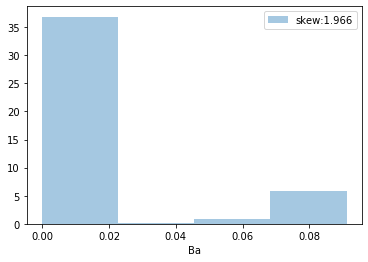

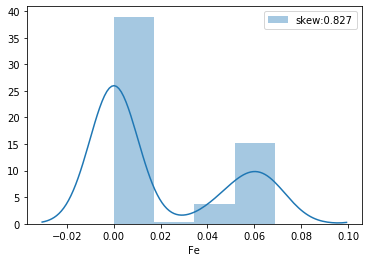

In [26]:
#lets check the distribution and skewness again

for feature in features:
    skew = data_bcox[feature].skew()
    sns.distplot(data_bcox[feature],label='skew:%.3f'%(skew),bins=4)
    plt.legend(loc='best')
    plt.show()

So seen from graph skewness is greatly reduced, but still not normalized, so after few test I realised it did not greatly improve the model performances

### Feature Importance

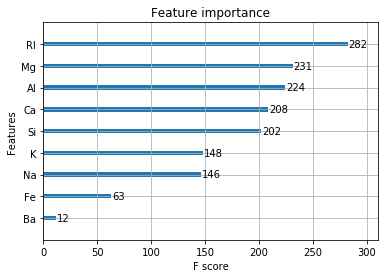

In [27]:
model_importances = XGBClassifier()
model_importances.fit(X_train, y_train)
plot_importance(model_importances)
plt.show()

from above plot no extemely dominant feature is found

# Machine Learning Modeling

### Logistic Regression

In [28]:
# logistic Regression

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

classifier_lr = LogisticRegression()
steps = [
    ('scalar', StandardScaler()),
    ('model', LogisticRegression())
]

lr_pipe = Pipeline(steps)

#defining parameter grid
parameters = { 'model__C' : [1,10,100,1000,10000],
               'model__fit_intercept' : [True],
               'model__multi_class' : ['auto'],
               'model__tol' : [0.0001],
               'model__solver' : ['newton-cg', 'lbfgs', 'sag', 'saga'],
               'model__n_jobs' : [-1],
               'model__max_iter' : [5000],
               'model__random_state': [42] 
}
classifier_lr = GridSearchCV(lr_pipe, parameters, cv = 5)
classifier_lr = classifier_lr.fit(X_train, y_train.ravel())

In [29]:
from sklearn.metrics import accuracy_score

y_pred_lr_train = classifier_lr.predict(X_train)
accuracy_lr_train = accuracy_score(y_train, y_pred_lr_train)
print("Training set: ", accuracy_lr_train)

y_pred_lr_test = classifier_lr.predict(X_test)
accuracy_lr_test = accuracy_score(y_test, y_pred_lr_test)
print("Test set: ", accuracy_lr_test)

Training set:  0.71875
Test set:  0.7


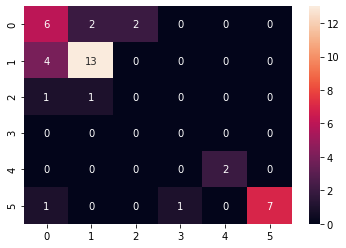

In [30]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr_test), annot=True, fmt='.0f')

### Support Vector Machine

In [31]:
from sklearn.svm import SVC
classifier_svm = SVC()
steps = [
    ('scalar', StandardScaler()),
    ('model', SVC())
]
svm_pipe = Pipeline(steps)

# parameter grid
parameters = { 'model__kernel' : ['rbf', 'poly', 'sigmoid'],
               'model__C' : [1,10,100,1000,10000],
               'model__gamma' : [0.001, 0.01, 0.1, 1, 'scale'],
               'model__random_state' : [42],
               'model__degree' : [1,2,3]
}
classifier_svm = GridSearchCV(svm_pipe, parameters, cv = 5)
classifier_svm = classifier_svm.fit(X_train, y_train.ravel())

In [32]:
y_pred_svm_train = classifier_svm.predict(X_train)
accuracy_svm_train = accuracy_score(y_train, y_pred_svm_train)
print("Training set: ", accuracy_svm_train)

y_pred_svm_test = classifier_svm.predict(X_test)
accuracy_svm_test = accuracy_score(y_test, y_pred_svm_test)
print("Test set: ", accuracy_svm_test)

Training set:  0.8375
Test set:  0.625


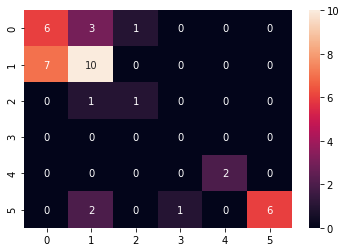

In [33]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_svm_test), annot=True, fmt='.0f')
plt.show()

### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
classifier_rf = RandomForestClassifier()

steps = [
    ('scalar', StandardScaler()),
    ('model', RandomForestClassifier())
]
rf_pipe = Pipeline(steps)

#parameter grid

parameters =  { "model__n_estimators": [100,500],
                "model__max_features": ["auto", "sqrt"],
                "model__max_depth": np.linspace(10, 110, num = 11),
                "model__min_samples_split": [2, 5],
                "model__min_samples_leaf": [1, 2, 4],
                "model__bootstrap": [True, False],
                "model__criterion": ["gini"],
                "model__random_state" : [42] }
            
classifier_rf = RandomizedSearchCV(estimator = rf_pipe,
                                  param_distributions = parameters,
                                  n_iter = 100,
                                  cv = 5,
                                  random_state=42,
                                  verbose = 4,
                                  n_jobs = -1)

classifier_rf = classifier_rf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.2min finished


In [35]:
y_pred_rf_train = classifier_rf.predict(X_train)
accuracy_rf_train = accuracy_score(y_train, y_pred_rf_train)
print("Training set: ", accuracy_rf_train)

y_pred_rf_test = classifier_rf.predict(X_test)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf_test)
print("Test set: ", accuracy_rf_test)

Training set:  0.98125
Test set:  0.825


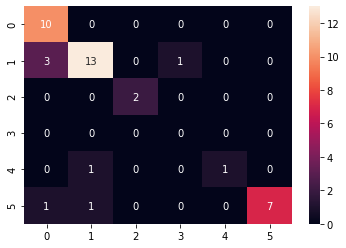

In [36]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf_test), annot=True, fmt='.0f')
plt.show()

### XGBoost Classifier

In [37]:
steps=[('scalar',StandardScaler()),
      ('model',XGBClassifier())]
xgb_pipe=Pipeline(steps)

#parameter grid

params = {
    'model__learning_rate':[0.001,0.005,0.01,0.05,0.10],
    'model__gamma': [0.1,0.5, 1, 1.5, 2, 5],
    'model__subsample': [0.6, 0.8],
    'model__n_estimators': [10,100,1000,2000],
    'model__seed':[10]
        }



classifier_xgb = RandomizedSearchCV(estimator = xgb_pipe,
                                  param_distributions = params,
                                  n_iter = 100,
                                  cv = 5,
                                  random_state=42,
                                  verbose = 4,
                                  n_jobs = -1)
                                


In [38]:
classifier_xgb = classifier_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.9min finished


In [39]:
y_pred_xgb_train = classifier_xgb.predict(X_train)
accuracy_xgb_train = accuracy_score(y_train, y_pred_xgb_train)
print("Training set: ", accuracy_xgb_train)

y_pred_xgb_test = classifier_xgb.predict(X_test)
accuracy_xgb_test = accuracy_score(y_test, y_pred_xgb_test)
print("Test set: ", accuracy_xgb_test)

Training set:  0.975
Test set:  0.8


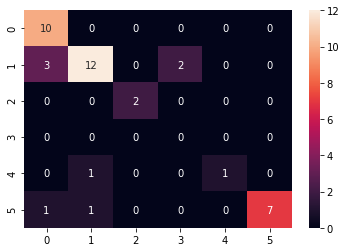

In [40]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb_test), annot=True, fmt='.0f')
plt.show()

### Artificial Neural Networks (ANN)

In [41]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

In [42]:
# Feature Scaling
sc_X = StandardScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_test_scaled = sc_X.fit_transform(X_test)

# Defining a function to encode output column
from keras.utils import to_categorical
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

y_train_encoded = encode(y_train)
y_test_encoded = encode(y_test)

Shape of data (BEFORE encode): (160,)
Shape of data (AFTER  encode): (160, 8)

Shape of data (BEFORE encode): (40,)
Shape of data (AFTER  encode): (40, 8)



In [43]:
y_train_encoded = np.delete(y_train_encoded, [0,4], axis = 1)
y_test_encoded = np.delete(y_test_encoded, [0,4], axis = 1)

In [44]:
print(y_train_encoded[2])
print(y_test_encoded[2])

[0. 0. 0. 0. 0. 1.]
[0. 1. 0. 0. 0. 0.]


In [45]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
output = classifier.fit(X_train_scaled, y_train_encoded,validation_data=(X_test_scaled, y_test_encoded), batch_size = 100, epochs = 1500)


Epoch 1/1500
2/2 [==============================] - 0s 204ms/step - loss: 1.7916 - accuracy: 0.1688 - val_loss: 1.7904 - val_accuracy: 0.4000
Epoch 2/1500
2/2 [==============================] - 0s 16ms/step - loss: 1.7900 - accuracy: 0.3313 - val_loss: 1.7889 - val_accuracy: 0.4000
Epoch 3/1500
2/2 [==============================] - 0s 14ms/step - loss: 1.7885 - accuracy: 0.3250 - val_loss: 1.7875 - val_accuracy: 0.4250
Epoch 4/1500
2/2 [==============================] - 0s 30ms/step - loss: 1.7869 - accuracy: 0.3313 - val_loss: 1.7861 - val_accuracy: 0.4250
Epoch 5/1500
2/2 [==============================] - 0s 19ms/step - loss: 1.7854 - accuracy: 0.3313 - val_loss: 1.7846 - val_accuracy: 0.4250
Epoch 6/1500
2/2 [==============================] - 0s 21ms/step - loss: 1.7839 - accuracy: 0.3313 - val_loss: 1.7831 - val_accuracy: 0.4250
Epoch 7/1500
2/2 [==============================] - 0s 19ms/step - loss: 1.7823 - accuracy: 0.3313 - val_loss: 1.7816 - val_accuracy: 0.4250
Epoch 8/1500

Epoch 59/1500
2/2 [==============================] - 0s 12ms/step - loss: 1.5160 - accuracy: 0.4187 - val_loss: 1.4666 - val_accuracy: 0.6000
Epoch 60/1500
2/2 [==============================] - 0s 15ms/step - loss: 1.5055 - accuracy: 0.4187 - val_loss: 1.4538 - val_accuracy: 0.6000
Epoch 61/1500
2/2 [==============================] - 0s 12ms/step - loss: 1.4949 - accuracy: 0.4125 - val_loss: 1.4408 - val_accuracy: 0.6000
Epoch 62/1500
2/2 [==============================] - 0s 13ms/step - loss: 1.4838 - accuracy: 0.4125 - val_loss: 1.4280 - val_accuracy: 0.6000
Epoch 63/1500
2/2 [==============================] - 0s 10ms/step - loss: 1.4730 - accuracy: 0.4125 - val_loss: 1.4152 - val_accuracy: 0.6000
Epoch 64/1500
2/2 [==============================] - 0s 15ms/step - loss: 1.4617 - accuracy: 0.4125 - val_loss: 1.4027 - val_accuracy: 0.6000
Epoch 65/1500
2/2 [==============================] - 0s 14ms/step - loss: 1.4511 - accuracy: 0.4125 - val_loss: 1.3900 - val_accuracy: 0.6000
Epoch 

2/2 [==============================] - 0s 11ms/step - loss: 1.1248 - accuracy: 0.5312 - val_loss: 1.1026 - val_accuracy: 0.5500
Epoch 117/1500
2/2 [==============================] - 0s 11ms/step - loss: 1.1216 - accuracy: 0.5562 - val_loss: 1.1013 - val_accuracy: 0.5750
Epoch 118/1500
2/2 [==============================] - 0s 11ms/step - loss: 1.1186 - accuracy: 0.5875 - val_loss: 1.0999 - val_accuracy: 0.5750
Epoch 119/1500
2/2 [==============================] - 0s 11ms/step - loss: 1.1156 - accuracy: 0.6187 - val_loss: 1.0987 - val_accuracy: 0.5750
Epoch 120/1500
2/2 [==============================] - 0s 15ms/step - loss: 1.1126 - accuracy: 0.6187 - val_loss: 1.0975 - val_accuracy: 0.5750
Epoch 121/1500
2/2 [==============================] - 0s 15ms/step - loss: 1.1099 - accuracy: 0.6250 - val_loss: 1.0964 - val_accuracy: 0.5750
Epoch 122/1500
2/2 [==============================] - 0s 11ms/step - loss: 1.1068 - accuracy: 0.6313 - val_loss: 1.0951 - val_accuracy: 0.5750
Epoch 123/1500

Epoch 173/1500
2/2 [==============================] - 0s 6ms/step - loss: 0.9600 - accuracy: 0.6438 - val_loss: 1.0759 - val_accuracy: 0.5750
Epoch 174/1500
2/2 [==============================] - 0s 13ms/step - loss: 0.9576 - accuracy: 0.6438 - val_loss: 1.0771 - val_accuracy: 0.5750
Epoch 175/1500
2/2 [==============================] - 0s 6ms/step - loss: 0.9553 - accuracy: 0.6438 - val_loss: 1.0781 - val_accuracy: 0.5750
Epoch 176/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.9527 - accuracy: 0.6438 - val_loss: 1.0789 - val_accuracy: 0.5750
Epoch 177/1500
2/2 [==============================] - 0s 13ms/step - loss: 0.9504 - accuracy: 0.6438 - val_loss: 1.0804 - val_accuracy: 0.5750
Epoch 178/1500
2/2 [==============================] - 0s 14ms/step - loss: 0.9481 - accuracy: 0.6438 - val_loss: 1.0818 - val_accuracy: 0.5750
Epoch 179/1500
2/2 [==============================] - 0s 8ms/step - loss: 0.9459 - accuracy: 0.6438 - val_loss: 1.0834 - val_accuracy: 0.5750
Ep

2/2 [==============================] - 0s 12ms/step - loss: 0.8688 - accuracy: 0.6438 - val_loss: 1.1384 - val_accuracy: 0.5750
Epoch 231/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.8679 - accuracy: 0.6438 - val_loss: 1.1391 - val_accuracy: 0.5750
Epoch 232/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.8670 - accuracy: 0.6438 - val_loss: 1.1395 - val_accuracy: 0.5750
Epoch 233/1500
2/2 [==============================] - 0s 16ms/step - loss: 0.8660 - accuracy: 0.6438 - val_loss: 1.1400 - val_accuracy: 0.5750
Epoch 234/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.8649 - accuracy: 0.6438 - val_loss: 1.1412 - val_accuracy: 0.5750
Epoch 235/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.8640 - accuracy: 0.6438 - val_loss: 1.1429 - val_accuracy: 0.5750
Epoch 236/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.8631 - accuracy: 0.6438 - val_loss: 1.1444 - val_accuracy: 0.5750
Epoch 237/1500

2/2 [==============================] - 0s 14ms/step - loss: 0.8299 - accuracy: 0.6625 - val_loss: 1.1759 - val_accuracy: 0.5750
Epoch 288/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.8296 - accuracy: 0.6562 - val_loss: 1.1752 - val_accuracy: 0.5750
Epoch 289/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.8290 - accuracy: 0.6625 - val_loss: 1.1752 - val_accuracy: 0.5750
Epoch 290/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.8286 - accuracy: 0.6625 - val_loss: 1.1747 - val_accuracy: 0.5750
Epoch 291/1500
2/2 [==============================] - 0s 15ms/step - loss: 0.8283 - accuracy: 0.6625 - val_loss: 1.1746 - val_accuracy: 0.5750
Epoch 292/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.8277 - accuracy: 0.6625 - val_loss: 1.1751 - val_accuracy: 0.5750
Epoch 293/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.8274 - accuracy: 0.6625 - val_loss: 1.1759 - val_accuracy: 0.5750
Epoch 294/1500

2/2 [==============================] - 0s 11ms/step - loss: 0.8086 - accuracy: 0.6750 - val_loss: 1.2065 - val_accuracy: 0.5750
Epoch 345/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.8083 - accuracy: 0.6750 - val_loss: 1.2060 - val_accuracy: 0.5750
Epoch 346/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.8079 - accuracy: 0.6750 - val_loss: 1.2056 - val_accuracy: 0.5750
Epoch 347/1500
2/2 [==============================] - 0s 17ms/step - loss: 0.8077 - accuracy: 0.6750 - val_loss: 1.2051 - val_accuracy: 0.5750
Epoch 348/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.8073 - accuracy: 0.6750 - val_loss: 1.2057 - val_accuracy: 0.5750
Epoch 349/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.8070 - accuracy: 0.6750 - val_loss: 1.2061 - val_accuracy: 0.5750
Epoch 350/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.8067 - accuracy: 0.6750 - val_loss: 1.2072 - val_accuracy: 0.5750
Epoch 351/1500

2/2 [==============================] - 0s 12ms/step - loss: 0.7860 - accuracy: 0.6875 - val_loss: 1.2491 - val_accuracy: 0.5500
Epoch 402/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.7856 - accuracy: 0.6875 - val_loss: 1.2500 - val_accuracy: 0.5500
Epoch 403/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.7853 - accuracy: 0.6875 - val_loss: 1.2510 - val_accuracy: 0.5500
Epoch 404/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.7848 - accuracy: 0.6938 - val_loss: 1.2522 - val_accuracy: 0.5500
Epoch 405/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.7845 - accuracy: 0.6938 - val_loss: 1.2536 - val_accuracy: 0.5500
Epoch 406/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.7842 - accuracy: 0.6938 - val_loss: 1.2541 - val_accuracy: 0.5500
Epoch 407/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.7841 - accuracy: 0.6938 - val_loss: 1.2548 - val_accuracy: 0.5500
Epoch 408/1500

2/2 [==============================] - 0s 14ms/step - loss: 0.7624 - accuracy: 0.6875 - val_loss: 1.2987 - val_accuracy: 0.5500
Epoch 459/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.7622 - accuracy: 0.6875 - val_loss: 1.3002 - val_accuracy: 0.5500
Epoch 460/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.7615 - accuracy: 0.6875 - val_loss: 1.3039 - val_accuracy: 0.5500
Epoch 461/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.7608 - accuracy: 0.6875 - val_loss: 1.3086 - val_accuracy: 0.5500
Epoch 462/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.7605 - accuracy: 0.6875 - val_loss: 1.3133 - val_accuracy: 0.5500
Epoch 463/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.7599 - accuracy: 0.6875 - val_loss: 1.3170 - val_accuracy: 0.5500
Epoch 464/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.7594 - accuracy: 0.6875 - val_loss: 1.3201 - val_accuracy: 0.5500
Epoch 465/1500

2/2 [==============================] - 0s 12ms/step - loss: 0.7383 - accuracy: 0.7188 - val_loss: 1.3689 - val_accuracy: 0.5500
Epoch 516/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.7379 - accuracy: 0.7188 - val_loss: 1.3694 - val_accuracy: 0.5500
Epoch 517/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.7376 - accuracy: 0.7188 - val_loss: 1.3698 - val_accuracy: 0.5500
Epoch 518/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.7372 - accuracy: 0.7188 - val_loss: 1.3716 - val_accuracy: 0.5500
Epoch 519/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.7368 - accuracy: 0.7188 - val_loss: 1.3726 - val_accuracy: 0.5500
Epoch 520/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.7363 - accuracy: 0.7125 - val_loss: 1.3739 - val_accuracy: 0.5500
Epoch 521/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.7360 - accuracy: 0.7125 - val_loss: 1.3755 - val_accuracy: 0.5500
Epoch 522/1500

2/2 [==============================] - 0s 11ms/step - loss: 0.7152 - accuracy: 0.7188 - val_loss: 1.4022 - val_accuracy: 0.5250
Epoch 573/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.7147 - accuracy: 0.7250 - val_loss: 1.4024 - val_accuracy: 0.5250
Epoch 574/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.7144 - accuracy: 0.7250 - val_loss: 1.4023 - val_accuracy: 0.5250
Epoch 575/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.7141 - accuracy: 0.7250 - val_loss: 1.4030 - val_accuracy: 0.5250
Epoch 576/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.7135 - accuracy: 0.7250 - val_loss: 1.4053 - val_accuracy: 0.5250
Epoch 577/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.7130 - accuracy: 0.7250 - val_loss: 1.4071 - val_accuracy: 0.5250
Epoch 578/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.7127 - accuracy: 0.7250 - val_loss: 1.4097 - val_accuracy: 0.5250
Epoch 579/1500

2/2 [==============================] - 0s 12ms/step - loss: 0.6899 - accuracy: 0.7250 - val_loss: 1.4306 - val_accuracy: 0.5250
Epoch 630/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.6895 - accuracy: 0.7250 - val_loss: 1.4324 - val_accuracy: 0.5250
Epoch 631/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.6889 - accuracy: 0.7250 - val_loss: 1.4352 - val_accuracy: 0.5250
Epoch 632/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.6886 - accuracy: 0.7312 - val_loss: 1.4374 - val_accuracy: 0.5250
Epoch 633/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.6882 - accuracy: 0.7312 - val_loss: 1.4383 - val_accuracy: 0.5250
Epoch 634/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.6877 - accuracy: 0.7312 - val_loss: 1.4386 - val_accuracy: 0.5250
Epoch 635/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.6873 - accuracy: 0.7312 - val_loss: 1.4377 - val_accuracy: 0.5250
Epoch 636/1500

2/2 [==============================] - 0s 4ms/step - loss: 0.6621 - accuracy: 0.7500 - val_loss: 1.4555 - val_accuracy: 0.5500
Epoch 687/1500
2/2 [==============================] - 0s 14ms/step - loss: 0.6617 - accuracy: 0.7500 - val_loss: 1.4560 - val_accuracy: 0.5500
Epoch 688/1500
2/2 [==============================] - 0s 13ms/step - loss: 0.6611 - accuracy: 0.7500 - val_loss: 1.4582 - val_accuracy: 0.5500
Epoch 689/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.6606 - accuracy: 0.7500 - val_loss: 1.4606 - val_accuracy: 0.5500
Epoch 690/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.6600 - accuracy: 0.7500 - val_loss: 1.4646 - val_accuracy: 0.5500
Epoch 691/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.6594 - accuracy: 0.7500 - val_loss: 1.4672 - val_accuracy: 0.5500
Epoch 692/1500
2/2 [==============================] - 0s 13ms/step - loss: 0.6588 - accuracy: 0.7437 - val_loss: 1.4703 - val_accuracy: 0.5500
Epoch 693/1500


2/2 [==============================] - 0s 13ms/step - loss: 0.6320 - accuracy: 0.7625 - val_loss: 1.5140 - val_accuracy: 0.6000
Epoch 744/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.6315 - accuracy: 0.7625 - val_loss: 1.5156 - val_accuracy: 0.6000
Epoch 745/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.6308 - accuracy: 0.7625 - val_loss: 1.5172 - val_accuracy: 0.6000
Epoch 746/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.6303 - accuracy: 0.7688 - val_loss: 1.5184 - val_accuracy: 0.6000
Epoch 747/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.6297 - accuracy: 0.7688 - val_loss: 1.5191 - val_accuracy: 0.6000
Epoch 748/1500
2/2 [==============================] - 0s 54ms/step - loss: 0.6292 - accuracy: 0.7688 - val_loss: 1.5193 - val_accuracy: 0.6000
Epoch 749/1500
2/2 [==============================] - 0s 27ms/step - loss: 0.6286 - accuracy: 0.7688 - val_loss: 1.5185 - val_accuracy: 0.6000
Epoch 750/1500

2/2 [==============================] - 0s 11ms/step - loss: 0.5996 - accuracy: 0.7812 - val_loss: 1.5594 - val_accuracy: 0.6000
Epoch 801/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.5989 - accuracy: 0.7812 - val_loss: 1.5584 - val_accuracy: 0.6000
Epoch 802/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.5985 - accuracy: 0.7812 - val_loss: 1.5577 - val_accuracy: 0.6000
Epoch 803/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.5979 - accuracy: 0.7812 - val_loss: 1.5573 - val_accuracy: 0.6000
Epoch 804/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.5973 - accuracy: 0.7812 - val_loss: 1.5582 - val_accuracy: 0.6000
Epoch 805/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.5968 - accuracy: 0.7812 - val_loss: 1.5591 - val_accuracy: 0.6000
Epoch 806/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.5962 - accuracy: 0.7812 - val_loss: 1.5618 - val_accuracy: 0.6000
Epoch 807/1500

2/2 [==============================] - 0s 14ms/step - loss: 0.5680 - accuracy: 0.7875 - val_loss: 1.6340 - val_accuracy: 0.6000
Epoch 858/1500
2/2 [==============================] - 0s 10ms/step - loss: 0.5673 - accuracy: 0.7875 - val_loss: 1.6331 - val_accuracy: 0.6000
Epoch 859/1500
2/2 [==============================] - 0s 18ms/step - loss: 0.5667 - accuracy: 0.7875 - val_loss: 1.6321 - val_accuracy: 0.6000
Epoch 860/1500
2/2 [==============================] - 0s 17ms/step - loss: 0.5662 - accuracy: 0.7875 - val_loss: 1.6317 - val_accuracy: 0.6000
Epoch 861/1500
2/2 [==============================] - 0s 15ms/step - loss: 0.5657 - accuracy: 0.7875 - val_loss: 1.6322 - val_accuracy: 0.6000
Epoch 862/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.5655 - accuracy: 0.7875 - val_loss: 1.6334 - val_accuracy: 0.6000
Epoch 863/1500
2/2 [==============================] - 0s 13ms/step - loss: 0.5646 - accuracy: 0.7875 - val_loss: 1.6323 - val_accuracy: 0.6000
Epoch 864/1500

2/2 [==============================] - 0s 16ms/step - loss: 0.5388 - accuracy: 0.8062 - val_loss: 1.7086 - val_accuracy: 0.6000
Epoch 915/1500
2/2 [==============================] - 0s 14ms/step - loss: 0.5382 - accuracy: 0.8062 - val_loss: 1.7097 - val_accuracy: 0.6000
Epoch 916/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.5377 - accuracy: 0.8062 - val_loss: 1.7107 - val_accuracy: 0.6000
Epoch 917/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.5373 - accuracy: 0.8062 - val_loss: 1.7129 - val_accuracy: 0.6000
Epoch 918/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.5369 - accuracy: 0.8062 - val_loss: 1.7142 - val_accuracy: 0.6000
Epoch 919/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.5364 - accuracy: 0.8062 - val_loss: 1.7142 - val_accuracy: 0.6000
Epoch 920/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.5359 - accuracy: 0.8062 - val_loss: 1.7140 - val_accuracy: 0.6000
Epoch 921/1500

2/2 [==============================] - 0s 11ms/step - loss: 0.5112 - accuracy: 0.8188 - val_loss: 1.7968 - val_accuracy: 0.6000
Epoch 972/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.5106 - accuracy: 0.8188 - val_loss: 1.8001 - val_accuracy: 0.6000
Epoch 973/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.5101 - accuracy: 0.8188 - val_loss: 1.8031 - val_accuracy: 0.6000
Epoch 974/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.5097 - accuracy: 0.8188 - val_loss: 1.8058 - val_accuracy: 0.6000
Epoch 975/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.5093 - accuracy: 0.8188 - val_loss: 1.8090 - val_accuracy: 0.6000
Epoch 976/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.5089 - accuracy: 0.8188 - val_loss: 1.8152 - val_accuracy: 0.6000
Epoch 977/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.5084 - accuracy: 0.8188 - val_loss: 1.8194 - val_accuracy: 0.6000
Epoch 978/1500

2/2 [==============================] - 0s 6ms/step - loss: 0.4876 - accuracy: 0.8375 - val_loss: 1.8947 - val_accuracy: 0.6250
Epoch 1029/1500
2/2 [==============================] - 0s 13ms/step - loss: 0.4871 - accuracy: 0.8375 - val_loss: 1.8942 - val_accuracy: 0.6250
Epoch 1030/1500
2/2 [==============================] - 0s 14ms/step - loss: 0.4868 - accuracy: 0.8375 - val_loss: 1.8933 - val_accuracy: 0.6250
Epoch 1031/1500
2/2 [==============================] - 0s 9ms/step - loss: 0.4864 - accuracy: 0.8375 - val_loss: 1.8933 - val_accuracy: 0.6250
Epoch 1032/1500
2/2 [==============================] - 0s 14ms/step - loss: 0.4860 - accuracy: 0.8313 - val_loss: 1.8929 - val_accuracy: 0.6250
Epoch 1033/1500
2/2 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.85 - 0s 4ms/step - loss: 0.4859 - accuracy: 0.8313 - val_loss: 1.8922 - val_accuracy: 0.6250
Epoch 1034/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.4856 - accuracy: 0.8313 - val_loss:

Epoch 1085/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.4679 - accuracy: 0.8375 - val_loss: 1.9500 - val_accuracy: 0.6250
Epoch 1086/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.4676 - accuracy: 0.8375 - val_loss: 1.9537 - val_accuracy: 0.6250
Epoch 1087/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.4671 - accuracy: 0.8375 - val_loss: 1.9568 - val_accuracy: 0.6250
Epoch 1088/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.4668 - accuracy: 0.8375 - val_loss: 1.9591 - val_accuracy: 0.6250
Epoch 1089/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.4665 - accuracy: 0.8438 - val_loss: 1.9614 - val_accuracy: 0.6250
Epoch 1090/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.4663 - accuracy: 0.8438 - val_loss: 1.9621 - val_accuracy: 0.6250
Epoch 1091/1500
2/2 [==============================] - 0s 16ms/step - loss: 0.4658 - accuracy: 0.8438 - val_loss: 1.9613 - val_accuracy:

2/2 [==============================] - 0s 11ms/step - loss: 0.4504 - accuracy: 0.8375 - val_loss: 2.0238 - val_accuracy: 0.6250
Epoch 1142/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.4501 - accuracy: 0.8375 - val_loss: 2.0235 - val_accuracy: 0.6250
Epoch 1143/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.4498 - accuracy: 0.8375 - val_loss: 2.0241 - val_accuracy: 0.6250
Epoch 1144/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.4495 - accuracy: 0.8375 - val_loss: 2.0266 - val_accuracy: 0.6250
Epoch 1145/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.4492 - accuracy: 0.8375 - val_loss: 2.0276 - val_accuracy: 0.6250
Epoch 1146/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.4489 - accuracy: 0.8375 - val_loss: 2.0282 - val_accuracy: 0.6250
Epoch 1147/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.4486 - accuracy: 0.8375 - val_loss: 2.0286 - val_accuracy: 0.6250
Epoch 11

2/2 [==============================] - 0s 14ms/step - loss: 0.4344 - accuracy: 0.8438 - val_loss: 2.1022 - val_accuracy: 0.6250
Epoch 1198/1500
2/2 [==============================] - 0s 14ms/step - loss: 0.4343 - accuracy: 0.8500 - val_loss: 2.1028 - val_accuracy: 0.6250
Epoch 1199/1500
2/2 [==============================] - 0s 3ms/step - loss: 0.4339 - accuracy: 0.8500 - val_loss: 2.1028 - val_accuracy: 0.6250
Epoch 1200/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.4336 - accuracy: 0.8500 - val_loss: 2.1037 - val_accuracy: 0.6250
Epoch 1201/1500
2/2 [==============================] - 0s 9ms/step - loss: 0.4333 - accuracy: 0.8500 - val_loss: 2.1040 - val_accuracy: 0.6250
Epoch 1202/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.4330 - accuracy: 0.8500 - val_loss: 2.1059 - val_accuracy: 0.6250
Epoch 1203/1500
2/2 [==============================] - 0s 6ms/step - loss: 0.4328 - accuracy: 0.8500 - val_loss: 2.1074 - val_accuracy: 0.6250
Epoch 1204/

Epoch 1254/1500
2/2 [==============================] - 0s 8ms/step - loss: 0.4197 - accuracy: 0.8500 - val_loss: 2.1931 - val_accuracy: 0.6250
Epoch 1255/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.4195 - accuracy: 0.8500 - val_loss: 2.1952 - val_accuracy: 0.6250
Epoch 1256/1500
2/2 [==============================] - 0s 8ms/step - loss: 0.4194 - accuracy: 0.8500 - val_loss: 2.1969 - val_accuracy: 0.6250
Epoch 1257/1500
2/2 [==============================] - 0s 14ms/step - loss: 0.4190 - accuracy: 0.8500 - val_loss: 2.2011 - val_accuracy: 0.6250
Epoch 1258/1500
2/2 [==============================] - 0s 5ms/step - loss: 0.4189 - accuracy: 0.8500 - val_loss: 2.2039 - val_accuracy: 0.6250
Epoch 1259/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.4185 - accuracy: 0.8500 - val_loss: 2.2071 - val_accuracy: 0.6250
Epoch 1260/1500
2/2 [==============================] - 0s 7ms/step - loss: 0.4184 - accuracy: 0.8500 - val_loss: 2.2098 - val_accuracy: 0.6

Epoch 1311/1500
2/2 [==============================] - 0s 7ms/step - loss: 0.4040 - accuracy: 0.8500 - val_loss: 2.2775 - val_accuracy: 0.6250
Epoch 1312/1500
2/2 [==============================] - 0s 5ms/step - loss: 0.4039 - accuracy: 0.8500 - val_loss: 2.2803 - val_accuracy: 0.6250
Epoch 1313/1500
2/2 [==============================] - 0s 13ms/step - loss: 0.4037 - accuracy: 0.8500 - val_loss: 2.2819 - val_accuracy: 0.6250
Epoch 1314/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.4033 - accuracy: 0.8500 - val_loss: 2.2821 - val_accuracy: 0.6250
Epoch 1315/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.4031 - accuracy: 0.8500 - val_loss: 2.2819 - val_accuracy: 0.6250
Epoch 1316/1500
2/2 [==============================] - 0s 13ms/step - loss: 0.4028 - accuracy: 0.8500 - val_loss: 2.2818 - val_accuracy: 0.6250
Epoch 1317/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.4027 - accuracy: 0.8500 - val_loss: 2.2790 - val_accuracy: 0

Epoch 1368/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.3897 - accuracy: 0.8687 - val_loss: 2.3416 - val_accuracy: 0.6250
Epoch 1369/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.3893 - accuracy: 0.8687 - val_loss: 2.3423 - val_accuracy: 0.6250
Epoch 1370/1500
2/2 [==============================] - 0s 10ms/step - loss: 0.3891 - accuracy: 0.8625 - val_loss: 2.3425 - val_accuracy: 0.6250
Epoch 1371/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.3887 - accuracy: 0.8625 - val_loss: 2.3444 - val_accuracy: 0.6250
Epoch 1372/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.3885 - accuracy: 0.8625 - val_loss: 2.3460 - val_accuracy: 0.6250
Epoch 1373/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.3883 - accuracy: 0.8687 - val_loss: 2.3462 - val_accuracy: 0.6250
Epoch 1374/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.3882 - accuracy: 0.8625 - val_loss: 2.3465 - val_accuracy:

Epoch 1425/1500
2/2 [==============================] - 0s 15ms/step - loss: 0.3760 - accuracy: 0.8687 - val_loss: 2.4273 - val_accuracy: 0.6250
Epoch 1426/1500
2/2 [==============================] - 0s 15ms/step - loss: 0.3758 - accuracy: 0.8625 - val_loss: 2.4270 - val_accuracy: 0.6000
Epoch 1427/1500
2/2 [==============================] - 0s 14ms/step - loss: 0.3755 - accuracy: 0.8625 - val_loss: 2.4283 - val_accuracy: 0.6000
Epoch 1428/1500
2/2 [==============================] - 0s 15ms/step - loss: 0.3752 - accuracy: 0.8625 - val_loss: 2.4312 - val_accuracy: 0.6000
Epoch 1429/1500
2/2 [==============================] - 0s 14ms/step - loss: 0.3749 - accuracy: 0.8625 - val_loss: 2.4333 - val_accuracy: 0.6000
Epoch 1430/1500
2/2 [==============================] - 0s 16ms/step - loss: 0.3749 - accuracy: 0.8687 - val_loss: 2.4346 - val_accuracy: 0.6000
Epoch 1431/1500
2/2 [==============================] - 0s 13ms/step - loss: 0.3746 - accuracy: 0.8687 - val_loss: 2.4383 - val_accuracy:

Epoch 1482/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.3646 - accuracy: 0.8750 - val_loss: 2.5040 - val_accuracy: 0.6250
Epoch 1483/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.3645 - accuracy: 0.8750 - val_loss: 2.5047 - val_accuracy: 0.6250
Epoch 1484/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.3640 - accuracy: 0.8750 - val_loss: 2.5079 - val_accuracy: 0.6250
Epoch 1485/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.3638 - accuracy: 0.8750 - val_loss: 2.5108 - val_accuracy: 0.6250
Epoch 1486/1500
2/2 [==============================] - 0s 11ms/step - loss: 0.3639 - accuracy: 0.8750 - val_loss: 2.5122 - val_accuracy: 0.6250
Epoch 1487/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.3638 - accuracy: 0.8750 - val_loss: 2.5159 - val_accuracy: 0.6250
Epoch 1488/1500
2/2 [==============================] - 0s 12ms/step - loss: 0.3635 - accuracy: 0.8687 - val_loss: 2.5181 - val_accuracy:

In [46]:
print("Training set: ", output.history.get('accuracy')[-1])
print("Test set: ", output.history.get('val_accuracy')[-1])

Training set:  0.875
Test set:  0.6000000238418579


## Combining Results

In [47]:
list=[('Logistic Regression',accuracy_lr_train,accuracy_lr_train),
     ('Random Forest Classifier',accuracy_rf_train,accuracy_rf_test),
     ('SVM',accuracy_svm_train,accuracy_svm_test),
     ('XGBoost Classifier',accuracy_xgb_train,accuracy_xgb_test),
     ('ANN',output.history.get('accuracy')[-1],output.history.get('val_accuracy')[-1])]

In [48]:
#convert to data frame
df=pd.DataFrame(data=list,columns=['Model','Train Accuracy','Test Accuracy'])

In [49]:
df

,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.71875,0.71875
1,Random Forest Classifier,0.98125,0.82500
2,SVM,0.83750,0.62500
3,XGBoost Classifier,0.97500,0.80000
4,ANN,0.87500,0.60000


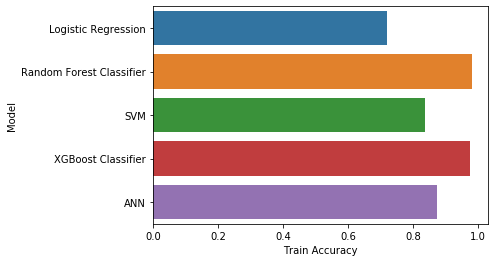

In [50]:
sns.barplot(x='Train Accuracy',y='Model',data=df)

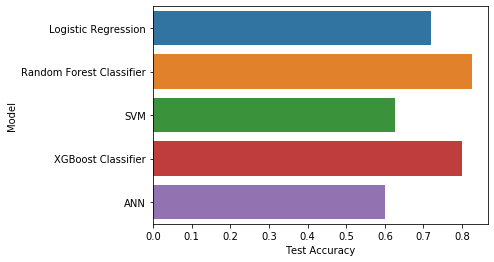

In [51]:
sns.barplot(x='Test Accuracy',y='Model',data=df)

# Conclusion

#### Random Forest Classifier gave accuracy of 82.50% on Test Dataset and 98.12% on Train dataset